In [251]:
# Import von Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import bisect

## Übung 2.1

##### Input-Parameter:

In [252]:
# Input - Parameter
Pv_kWp = 10             # Anlagengröße in kWp
Zinssatz = 0.06         # in %
Systemkosten = 800      # in €/kWp
Betriebskosten = 10     # in €/(kWp*a)
Lebensdauer = 20        # in Jahre

##### Eingeben/ Einlesen der gewünschten Daten

In [253]:
# PV-Einspeisung (MW/MWp)
dfEinspeisung = pd.read_csv("PV_Einspeisung.csv")

# Preise 2023 (ct/kWh)
dfPeise = pd.read_csv("ENTSOE_prices_for_2023_in_ct_per_kWh.csv", delimiter =";")
# Landesauswahl
Preise = dfPeise["AT"]
# Durchschnittspreis über das gesamter Jahr
Preise_NORM = np.mean(Preise)

# Erlöse
# Erlös = Einspeisung (MW/MWp) * Anlagengröße (kWp) * Preis (ct/kWh) /100
Erlöse_array = dfEinspeisung["0"] * Pv_kWp / 100 * Preise
Erlöse = np.sum(Erlöse_array)
# Erlöse Normiert
Erlöse_array_NORM = dfEinspeisung["0"] * Pv_kWp / 100 * Preise_NORM
Erlöse_NORM = np.sum(Erlöse_array_NORM)

# Investitionskosten
# ohne OeMAG
Investitionskosten_ohne_OeMAG = Pv_kWp*Systemkosten
# mit OeMag
Investitionskosten_mit_OeMAG = Pv_kWp*Systemkosten - np.minimum(195*Pv_kWp,(0.3*Pv_kWp*Systemkosten))

##### a) Barwertberechnung & Darstellung

In [254]:
def Barwert(Zinssatz, Betriebskosten, Lebensdauer, Erlöse, Investitionskosten):
    time = np.arange(0, Lebensdauer)
    NPV = np.zeros(shape=(Lebensdauer + 1,1))
    NPV[0][0] = -Investitionskosten
    NPV[1:, 0] = NPV[0][0] + np.cumsum((Erlöse - Betriebskosten) / ((1 + Zinssatz) ** time))
    return NPV.flatten()

In [255]:
def Grafik_Barwert(Zinssatz, Betriebskosten, Lebensdauer, Erlöse, Investitionskosten, mit_OeMAG=False, normiert=False):
    NPV = Barwert(Zinssatz, Betriebskosten, Lebensdauer, Erlöse, Investitionskosten)
    
    if mit_OeMAG:
        if normiert:
            titel = "Barwert Normiert mit OeMAG"
        else:
            titel = "Barwert mit OeMAG"
    else:
        if normiert:
            titel = "Barwert Normiert ohne OeMAG"
        else:
            titel = "Barwert ohne OeMAG"
        
    fig, ax = plt.subplots()
    ax.bar(np.arange(0, Lebensdauer + 1), NPV, zorder=2)
    ax.set_title(titel)
    ax.set_xlabel('t in Years')
    ax.set_ylabel('Yield in €')
    ax.grid(True, zorder=1)
    ax.set_xticks(range(0, Lebensdauer + 1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))  # Setzen der y-Tickpositionen in 1000er-Schritten

    
    plt.xlim(-1, Lebensdauer + 1)
    plt.show()

In [256]:
def Max_Investment(Zinssatz, Betriebskosten, Lebensdauer, Erlöse, Investitionskosten):
    def netto_barwert(Investitionskosten):
        time = np.arange(0, Lebensdauer)
        NPV = np.zeros(shape=(Lebensdauer + 1,1))
        NPV[0][0] = -Investitionskosten
        NPV[1:, 0] = NPV[0][0] + np.cumsum((Erlöse - Betriebskosten) / ((1 + Zinssatz) ** time))
        return NPV[-1][0]
    
    maximale_investitionskosten = bisect(netto_barwert, 0, 100000)
    print("Maximale Investitionskosten: {:.2f} €".format(maximale_investitionskosten))

##### b) Barwert ohne OeMAG & mit OeMAG

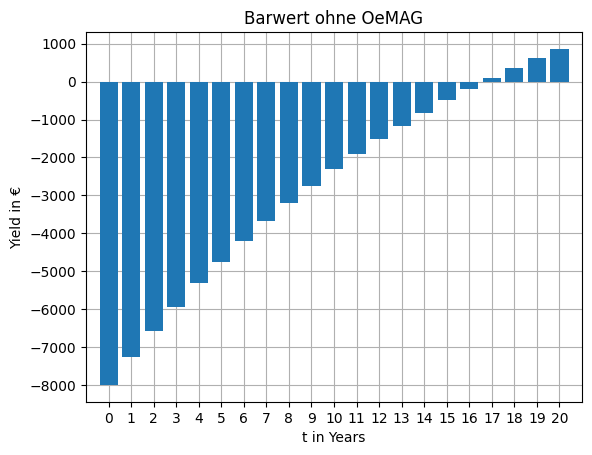

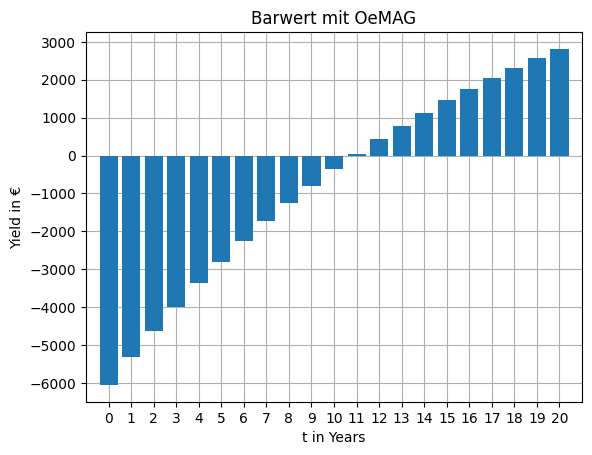

Maximale Investitionskosten: 8863.79 €


In [257]:
Grafik_Barwert(Zinssatz, Betriebskosten, Lebensdauer, Erlöse, Investitionskosten_ohne_OeMAG)
Grafik_Barwert(Zinssatz, Betriebskosten, Lebensdauer, Erlöse, Investitionskosten_mit_OeMAG, mit_OeMAG=True)
Max_Investment(Zinssatz, Betriebskosten, Lebensdauer, Erlöse, Investitionskosten_ohne_OeMAG)

##### c) Barwert Normiert 

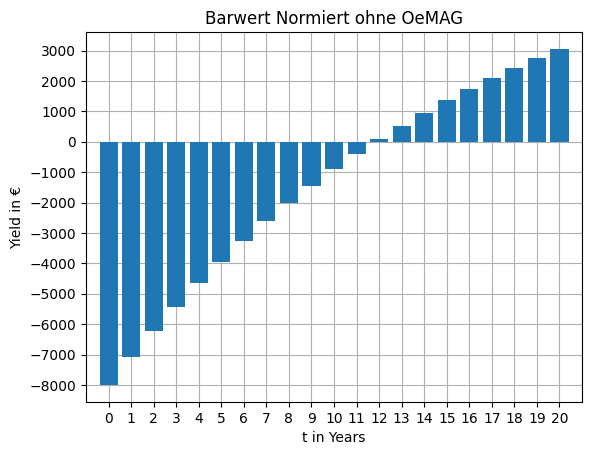

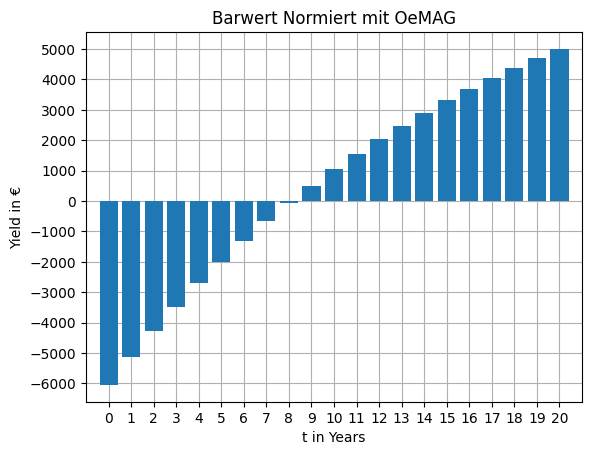

Maximale Investitionskosten: 11055.19 €


In [258]:
Grafik_Barwert(Zinssatz, Betriebskosten, Lebensdauer, Erlöse_NORM, Investitionskosten_ohne_OeMAG, normiert=True)
Grafik_Barwert(Zinssatz, Betriebskosten, Lebensdauer, Erlöse_NORM, Investitionskosten_mit_OeMAG, mit_OeMAG=True, normiert=True)
Max_Investment(Zinssatz, Betriebskosten, Lebensdauer, Erlöse_NORM, Investitionskosten_ohne_OeMAG)

## Übung 2.2

##### Input-Parameter & gewünschte Daten:

In [259]:
Anlage_Pv = 5                                           # in kWp
dfProduktion = pd.read_csv("PV_Profil_leistung_2.csv")  # Produktion der Anlage in kW/kWp
dfVerbrauch = pd.read_csv("LeistungHaushalte.csv", delimiter = ",")
dfVerbrauch_kWh = dfVerbrauch / 1000                    # Umrechnung Wh in kWh

# Auswählen Verbrauch vom gewünschten Haushalt:
Haushalt1 = dfVerbrauch_kWh["1"]
Haushalt2 = dfVerbrauch_kWh["2"]

##### a) Eigenverbrauch & Überschusseinspeisung:

In [260]:
def Eigenverbrauch_Einspeisung_Haushalt(Haushalt, Produktion, Pv_kWp):
    Eigenverbrauch = 0
    Überschusseinspeisung = 0
    
    #Sollen wir die Pv-KWp berücksichtigen ??? Wieso kriegen wir hohe werte ?
    Produktion_Anlage = Pv_kWp * Produktion
    
    # range(1,97) Erster Tag
    # range(1,2977) Monat mit 31 Tagen
    # range(1,2881) Monat mit 30 Tagen    
    for i in range(len(Haushalt)):
        if Produktion_Anlage[i] <= Haushalt[i]:
            Eigenverbrauch += Produktion_Anlage[i]
        else:
            Eigenverbrauch += Haushalt[i]
            Überschusseinspeisung += Produktion_Anlage[i] - Haushalt[i]
            
    #Alternative:
    #for pv, verbrauch in zip(Produktion_Anlage, Haushalt):
    #    Eigenverbrauch += min(pv, verbrauch)
    #    Überschusseinspeisung += max(0, pv - verbrauch)
    
    return Eigenverbrauch, Überschusseinspeisung

In [261]:
Eigenverbrauch_H1, Überschusseinspeisung_H1 = Eigenverbrauch_Einspeisung_Haushalt(Haushalt1, dfProduktion["Produktion"], Anlage_Pv)
Eigenverbrauch_H2, Überschusseinspeisung_H2 = Eigenverbrauch_Einspeisung_Haushalt(Haushalt2, dfProduktion["Produktion"], Anlage_Pv)

# Eigenverbrauch & Überschusseinspeisung Haushalt 1
gesamterzeugung_H1 = Eigenverbrauch_H1 + Überschusseinspeisung_H1
print("Haushalt 1:")
print(f"Eigenverbrauch:        {Eigenverbrauch_H1:>10.2f} kWh")
print(f"Überschusseinspeisung: {Überschusseinspeisung_H1:>10.2f} kWh")
print(f"PV-Gesamterzeugung:    {gesamterzeugung_H1:>10.2f} kWh")

# Eigenverbrauch & Überschusseinspeisung Haushalt 2
gesamterzeugung_H2 = Eigenverbrauch_H2 + Überschusseinspeisung_H2
print("")
print("Haushalt 2:")
print(f"Eigenverbrauch:        {Eigenverbrauch_H2:>10.2f} kWh")
print(f"Überschusseinspeisung: {Überschusseinspeisung_H2:>10.2f} kWh")
print(f"PV-Gesamterzeugung:    {gesamterzeugung_H2:>10.2f} kWh")


Haushalt 1:
Eigenverbrauch:           3282.13 kWh
Überschusseinspeisung:   15740.35 kWh
PV-Gesamterzeugung:      19022.48 kWh

Haushalt 2:
Eigenverbrauch:           2450.65 kWh
Überschusseinspeisung:   16571.83 kWh
PV-Gesamterzeugung:      19022.48 kWh


### b) Eigenverbrauchsanteil & Deckungsgrade

In [262]:
#Deckungsgrad beschreibt die Unabhängigkeit von anderen Energiequellen als der Sonne

def Anteile_Verbrauch_Deckungsgrad(Haushalt, Produktion, Anlage_Pv):
    Eigenverbrauchsanteile = []
    Deckungsgrade = []

    for i in range(1, 211, 1):  # Anlagengröße von 0 bis 20 kWp
        Anlage_size = i/10      # Schritte von 0.1kWp
        Eigenverbrauch, Überschusseinspeisung = Eigenverbrauch_Einspeisung_Haushalt(Haushalt, Produktion, Anlage_size)

        Gesamtproduktion = Produktion.sum() * Anlage_size
        Eigenverbrauchsanteil = Eigenverbrauch / Gesamtproduktion if Gesamtproduktion > 0 else 0
        Deckungsgrade.append(Überschusseinspeisung / Gesamtproduktion if Gesamtproduktion > 0 else 0)
        Eigenverbrauchsanteile.append(Eigenverbrauchsanteil)

    return Eigenverbrauchsanteile, Deckungsgrade


In [263]:
# Berechnen der Anteile für H1 & H2
Eigenverbrauchsanteile_H1, Deckungsgrade_H1 = Anteile_Verbrauch_Deckungsgrad(Haushalt1, dfProduktion["Produktion"], Anlage_Pv)
Eigenverbrauchsanteile_H2, Deckungsgrade_H2 = Anteile_Verbrauch_Deckungsgrad(Haushalt2, dfProduktion["Produktion"], Anlage_Pv)

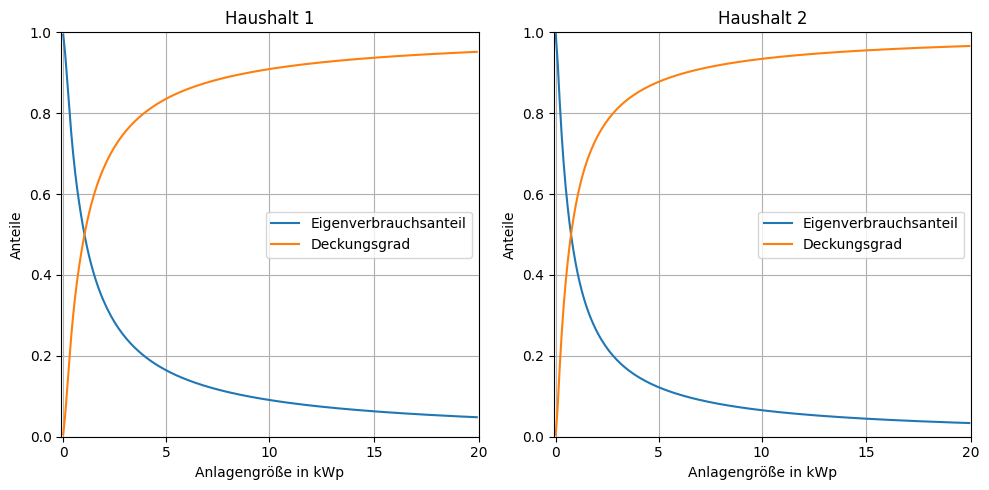

In [264]:
# Diagramme erstellen
plt.figure(figsize=(10, 5))

# Haushalt1
plt.subplot(1, 2, 1)
plt.plot(range(1, 211), Eigenverbrauchsanteile_H1, label='Eigenverbrauchsanteil')
plt.plot(range(1, 211), Deckungsgrade_H1, label='Deckungsgrad')
plt.xlabel('Anlagengröße in kWp')
plt.ylabel('Anteile')
plt.title('Haushalt 1')
plt.xticks([1, 53 , 105, 158, 211], ["0", "5", "10", "15", "20"])
plt.xlim(0, 211)  # Setze die Grenzen der x-Achse
plt.ylim(0, 1)   # Setze die Grenzen der y-Achse
plt.grid()
plt.legend()

# Haushalt2
plt.subplot(1, 2, 2)
plt.plot(range(1, 211), Eigenverbrauchsanteile_H2, label='Eigenverbrauchsanteil')
plt.plot(range(1, 211), Deckungsgrade_H2, label='Deckungsgrad')
plt.xlabel('Anlagengröße in kWp')
plt.xticks([1, 53 , 105, 158, 211], ["0", "5", "10", "15", "20"])
plt.xlim(0, 211)  # Setze die Grenzen der x-Achse
plt.ylim(0, 1)   # Setze die Grenzen der y-Achse
plt.ylabel('Anteile')
plt.title('Haushalt 2')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

##### c) Grafik Erzeugung, Last & Eigenverbrauch:

In [265]:
def Grafik(Haushalt ,Produktion, Pv_kWp, KW):
    
    W_start = 1 + (KW-1) * 672 
    W_end = 1 + (KW) * 672

    # Ticks für 7 Tage setzen
    ticks_per_day = 96  # 96 Werte pro Tag (15 Minuten Intervalle)
    days = 8
    ticks = np.arange(0, days * ticks_per_day, ticks_per_day)
    tick_labels = np.arange(0, days)

    #Erzeugung PV-Leistung
    Produktion_Anlage = Pv_kWp * Produktion
    # Eigenverbrauch
    Eigenverbrauch = np.minimum(Produktion_Anlage[W_start:W_end].iloc[:, 0], Haushalt[W_start:W_end])
  
    # Plot erstellen
    fig, ax = plt.subplots()
    ax.plot(np.arange(0, W_end - W_start), Haushalt[W_start:W_end], label="Last")
    ax.plot(np.arange(0, W_end - W_start), Produktion_Anlage[W_start:W_end], label="Erzeugung")
    ax.plot(np.arange(0, W_end - W_start), Eigenverbrauch, label="Eigenverbrauch")
    ax.fill_between(np.arange(0, W_end - W_start), 0, Eigenverbrauch, color='lightblue', alpha=0.5)  # Markierung der Fläche unter der Eigenverbrauchsfunktion

    ax.set_title(f"Woche {KW}")
    ax.set_xlabel(f'Zeit in Tagen von KW {KW}')
    ax.set_ylabel('Verbrauch in kWh')
    ax.grid(True, zorder=1)
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.legend()

    plt.xlim(0, 672)
    plt.ylim(0) 
    plt.show()

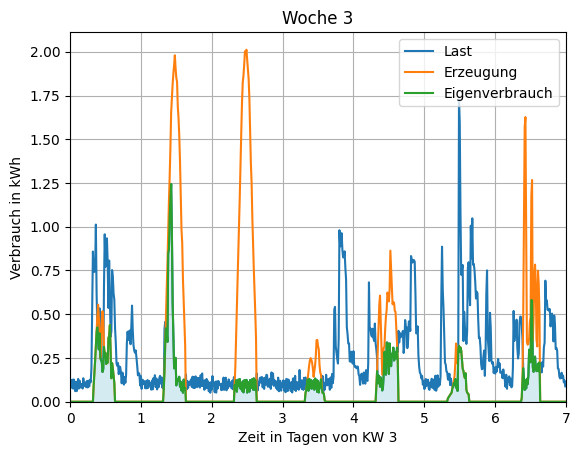

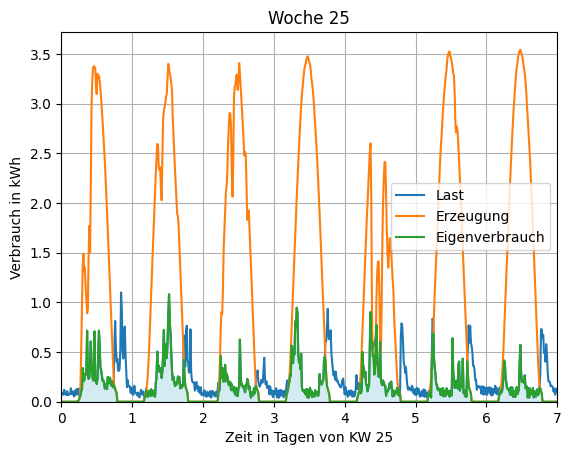

In [266]:
Grafik(Haushalt1, dfProduktion, Anlage_Pv, 3)
Grafik(Haushalt1, dfProduktion, Anlage_Pv, 25)

## 2.4

### a. Wie beurteilen Sie auf Basis der in der dieser Übung erlangten Erkenntnisse die Wirtschaftlichkeit von PV-Anlagen in Österreich?

Eine reine PV-Anlage in Österreich erzeugt aktuell im Zeitraum von einem Jahr genug Leistung um spätestens nach 20 Jahren wirtschaftlich zu sein. Die Leistung reicht aus um einen durchschnittlichen Haushalt über das gesamte Jahr mit Strom zu versorgen. Der Nachteil ist, dass im Sommer die Spitzen gespeichert werden müssen. Dies würde einen Energiespeicher erfordern (Kostenaufwand). Unserer Meinung nach ist sinnvoll, wenn jeder Haushalt eine PV-Anlage mit Energiespeicher hätte, dann würden im Sommer die Schwierigkeiten mit der Netzregelung nahezu vollständig ausfallen und damit können die eigenen Lastspitzen am Abend ausgeglichen werden. 

### b. Sollten Ihrer Meinung nach PV-Anlagen in Österreich weiterhin gefördert werden?

Wenn ein Land unabhängig von etwas bestimmtes sein möchte, dann ist es aufjedenfall notwenig das bestimmte etwas reichlich im Land zu haben. Der Energiemarkt wird in den nächsten Jahren immer mehr an Relevanz gewinnen. Abgesehen von elektrischer Energie kann mittels Photovoltaik auch thermische Energie gewonnen werden. Deshalb ist es unserer Meinung nach am sinnvollsten noch mehr Förderungen in Photovoltaik reinzustecken. 

Vorteile:
- Billiger Strom
- Reduktion der CO2-Emissionen
- Bessere Effizienz möglich mit dem Hinzufügen von Energiespeicher und Wärmepumpe
- Nahezu komplette Unabhängigkeit von Stromlieferanten möglich


Nachteile:
- Hohe Investition zu Beginn
- Wartung der Anlage, um die maximale Leistung beizubehalten
- Wirkungsgrad verringert sich nach 20 Jahren
